In [1]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from utils.model_utils import vicuna_7b, vicuna_13b
model = vicuna_7b(device="cuda")
model.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


Loaded pretrained model llama-7b-hf into HookedTransformer
Moving model to device:  cuda


1

In [3]:
from utils.dataset_utils import MS_Dataset, Elem_Dataset, MisCons_Dataset, Kinder_Dataset, HS_Dataset, BoolQ_Question_Dataset, TruthfulQA_Tfn, CounterFact_Tfn, Fever_Tfn, BoolQ_Tfn, Creak_Tfn, CommonClaim_Tfn
random_seed = 5

datanames = ["MS", "Elem", "MisCons", "Kinder", "HS", "TruthfulQA", "CounterFact", "Fever", "Creak", "BoolQ", "CommonClaim"]

ms_data = MS_Dataset(model.tokenizer, questions=True)
elem_data = Elem_Dataset(model.tokenizer, questions=True)
miscons_data = MisCons_Dataset(model.tokenizer, questions=True)
kinder_data = Kinder_Dataset(model.tokenizer, questions=True)
hs_data = HS_Dataset(model.tokenizer, questions=True)
# boolq_data = BoolQ_Question_Dataset(model.tokenizer)

tqa_data = TruthfulQA_Tfn(model.tokenizer, questions=True)
cfact_data = CounterFact_Tfn(model.tokenizer, questions=True)
fever_data = Fever_Tfn(model.tokenizer, questions=True)
boolq_data = BoolQ_Tfn(model.tokenizer, questions=True)
creak_data = Creak_Tfn(model.tokenizer, questions=True)
commonclaim_data = CommonClaim_Tfn(model.tokenizer, questions=True)

datasets = {"MS": ms_data, "Elem": elem_data, "MisCons": miscons_data, "Kinder": kinder_data, "HS": hs_data, "TruthfulQA": tqa_data, "CounterFact": cfact_data, "Fever": fever_data, "Creak": creak_data, "BoolQ": boolq_data, "CommonClaim": commonclaim_data}

datanames = datanames[:3]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--elem_tf-64ec49cd4cd5be64/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--ms_tf-728c6138d8f6c1c5/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--misconceptions_tf-131f43b181040ffa/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--kindergarten_tf-e3c53e366bc35ec1/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--hs_tf-9f911d9357ff2386/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
n_acts = 1000
acts = {}

for name in datanames:
    # acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "logits"])
    acts[name] = ModelActs(model, datasets[name], act_types=["z", "logits"])
    model_acts: ModelActs = acts[name]
    # model_acts.gen_acts(N=n_acts, id=f"{name}_gpt2xl_{n_acts}")
    model_acts.load_acts(id=f"{name}_vicuna7b_{n_acts}", load_probes=False)
    model_acts.train_probes("z", max_iter=1000)

torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1024/1024 [00:07<00:00, 132.11it/s]


torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1024/1024 [00:06<00:00, 159.95it/s]


torch.Size([800, 1024, 128]), torch.Size([200, 1024, 128]), torch.Size([800, 1024]), torch.Size([200, 1024])


100%|██████████| 1024/1024 [00:06<00:00, 165.39it/s]


In [6]:
from utils.interp_utils import logit_attrs
attrs = logit_attrs(model, datasets['MS'], act_types=["result"], N=200)
result_attrs = torch.stack(attrs[1]['result']).to('cpu')

100%|██████████| 200/200 [00:17<00:00, 11.11it/s]


In [22]:
# Plot Truth Score and Info Score when varying topk
from utils.gpt_judge import get_model_generations, get_judge_scores
from utils.iti_utils import patch_heads
from utils.interp_utils import get_head_bools, tot_logit_diff

seed = 0

alpha = 1
k_range = range(0, 32, 1)

logit_patch_accs = []
regular_patch_accs = []
# logit_patch_truths = []
# logit_patch_infos = []
# regular_patch_truths = []
# regular_patch_infos = []
# num_gens=200

# first, patching top logit heads:

dataname = "MS"
for k in tqdm(k_range):
    top_logit_heads = torch.topk(result_attrs.mean(dim=0), k=k).indices

    logit_bools = get_head_bools(model, top_logit_heads, flattened=True)
    model.reset_hooks()
    patch_heads(model, acts[dataname], logit_bools, alpha=alpha, use_MMD=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    # print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_vicuna7b_1000", indices=acts[dataname].indices)

    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False)

    logit_patch_accs.append(positive_sum.mean() - negative_sum.mean())

  0%|          | 0/32 [00:00<?, ?it/s]

generating acts


  3%|▎         | 1/32 [01:03<32:45, 63.42s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


  6%|▋         | 2/32 [02:06<31:36, 63.21s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


  9%|▉         | 3/32 [03:09<30:35, 63.29s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 12%|█▎        | 4/32 [04:12<29:27, 63.11s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 16%|█▌        | 5/32 [05:15<28:23, 63.08s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 19%|█▉        | 6/32 [06:18<27:21, 63.12s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 22%|██▏       | 7/32 [07:22<26:19, 63.16s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 25%|██▌       | 8/32 [08:25<25:15, 63.15s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 28%|██▊       | 9/32 [09:28<24:10, 63.09s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 31%|███▏      | 10/32 [10:31<23:09, 63.14s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 34%|███▍      | 11/32 [11:34<22:05, 63.12s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 38%|███▊      | 12/32 [12:38<21:04, 63.24s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 41%|████      | 13/32 [13:41<20:03, 63.36s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 44%|████▍     | 14/32 [14:44<18:59, 63.28s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 47%|████▋     | 15/32 [15:48<17:58, 63.41s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 50%|█████     | 16/32 [16:52<16:56, 63.56s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 53%|█████▎    | 17/32 [17:56<15:56, 63.77s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 56%|█████▋    | 18/32 [19:00<14:54, 63.87s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 59%|█████▉    | 19/32 [20:04<13:50, 63.88s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 62%|██████▎   | 20/32 [21:08<12:47, 63.93s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 66%|██████▌   | 21/32 [22:12<11:41, 63.77s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 69%|██████▉   | 22/32 [23:16<10:39, 64.00s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 72%|███████▏  | 23/32 [24:20<09:35, 63.94s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 75%|███████▌  | 24/32 [25:24<08:32, 64.06s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 78%|███████▊  | 25/32 [26:28<07:28, 64.05s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 81%|████████▏ | 26/32 [27:32<06:24, 64.05s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 84%|████████▍ | 27/32 [28:37<05:20, 64.09s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 88%|████████▊ | 28/32 [29:41<04:16, 64.08s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 91%|█████████ | 29/32 [30:45<03:12, 64.06s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 94%|█████████▍| 30/32 [31:48<02:07, 63.98s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 97%|█████████▋| 31/32 [32:52<01:03, 63.96s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


100%|██████████| 32/32 [33:56<00:00, 63.65s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49


In [23]:
logit_patch_accs

[tensor(0.4950),
 tensor(0.4959),
 tensor(0.4956),
 tensor(0.4933),
 tensor(0.4793),
 tensor(0.4770),
 tensor(0.4750),
 tensor(0.4715),
 tensor(0.4703),
 tensor(0.4677),
 tensor(0.4663),
 tensor(0.4672),
 tensor(0.4631),
 tensor(0.4350),
 tensor(0.4312),
 tensor(0.4300),
 tensor(0.4284),
 tensor(0.4255),
 tensor(0.4247),
 tensor(0.4141),
 tensor(0.3787),
 tensor(0.3787),
 tensor(0.3766),
 tensor(0.3585),
 tensor(0.3566),
 tensor(0.3450),
 tensor(0.3246),
 tensor(0.3200),
 tensor(0.3201),
 tensor(0.3178),
 tensor(0.3174),
 tensor(0.3055)]

In [24]:
from utils.iti_utils import patch_iti
dataname = "MS"
for k in tqdm(k_range):
    model.reset_hooks()
    patch_iti(model, acts[dataname], topk=k, alpha=alpha, use_MMD=True, model_device='cuda')

    patched_acts = ModelActs(model, datasets[dataname], act_types=["z","logits"])
    print("generating acts")
    patched_acts.gen_acts(N=1000, id=f"patched_{dataname}_vicuna7b_1000", indices=acts[dataname].indices)

    patched_acts.indices_trains=acts[dataname].indices_trains
    patched_acts.indices_tests=acts[dataname].indices_tests

    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, patched_acts, use_probs=True, check_balanced_output=False)

    regular_patch_accs.append(positive_sum.mean() - negative_sum.mean())

  0%|          | 0/32 [00:00<?, ?it/s]

generating acts


  3%|▎         | 1/32 [01:02<32:31, 62.95s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


  6%|▋         | 2/32 [02:05<31:23, 62.78s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


  9%|▉         | 3/32 [03:08<30:23, 62.90s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 12%|█▎        | 4/32 [04:11<29:25, 63.04s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 16%|█▌        | 5/32 [05:15<28:26, 63.20s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 19%|█▉        | 6/32 [06:18<27:21, 63.15s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 22%|██▏       | 7/32 [07:21<26:18, 63.12s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 25%|██▌       | 8/32 [08:25<25:18, 63.25s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 28%|██▊       | 9/32 [09:28<24:18, 63.40s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 31%|███▏      | 10/32 [10:32<23:18, 63.58s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 34%|███▍      | 11/32 [11:36<22:18, 63.73s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 38%|███▊      | 12/32 [12:40<21:13, 63.67s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 41%|████      | 13/32 [13:43<20:07, 63.56s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 44%|████▍     | 14/32 [14:47<19:04, 63.58s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 47%|████▋     | 15/32 [15:51<18:01, 63.62s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 50%|█████     | 16/32 [16:54<16:58, 63.65s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 53%|█████▎    | 17/32 [17:58<15:57, 63.80s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 56%|█████▋    | 18/32 [19:02<14:53, 63.79s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 59%|█████▉    | 19/32 [20:06<13:48, 63.76s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 62%|██████▎   | 20/32 [21:10<12:45, 63.81s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 66%|██████▌   | 21/32 [22:14<11:43, 63.92s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 69%|██████▉   | 22/32 [23:18<10:39, 63.95s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 72%|███████▏  | 23/32 [24:23<09:37, 64.13s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 75%|███████▌  | 24/32 [25:27<08:33, 64.18s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 78%|███████▊  | 25/32 [26:31<07:29, 64.24s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 81%|████████▏ | 26/32 [27:36<06:26, 64.35s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 84%|████████▍ | 27/32 [28:40<05:22, 64.45s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 88%|████████▊ | 28/32 [29:45<04:18, 64.56s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 91%|█████████ | 29/32 [30:50<03:13, 64.55s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 94%|█████████▍| 30/32 [31:55<02:09, 64.59s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


 97%|█████████▋| 31/32 [32:59<01:04, 64.44s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49
generating acts


100%|██████████| 32/32 [34:03<00:00, 63.86s/it]

Stored at patched_MS_vicuna7b_1000
proportion of positive labels is 0.49


In [25]:
regular_patch_accs

[tensor(0.4950),
 tensor(0.5005),
 tensor(0.4973),
 tensor(0.4945),
 tensor(0.4955),
 tensor(0.4906),
 tensor(0.4898),
 tensor(0.4862),
 tensor(0.4863),
 tensor(0.4862),
 tensor(0.4860),
 tensor(0.4860),
 tensor(0.4870),
 tensor(0.4897),
 tensor(0.4839),
 tensor(0.4838),
 tensor(0.4792),
 tensor(0.4782),
 tensor(0.4780),
 tensor(0.4753),
 tensor(0.4753),
 tensor(0.4768),
 tensor(0.4732),
 tensor(0.4651),
 tensor(0.4484),
 tensor(0.4482),
 tensor(0.4463),
 tensor(0.4479),
 tensor(0.4442),
 tensor(0.4443),
 tensor(0.4441),
 tensor(0.4420)]

Text(0, 0.5, 'Correct - Incorrect Label Responses')

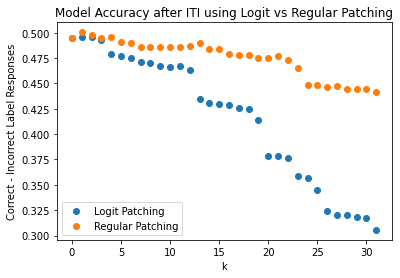

In [27]:
import matplotlib.pyplot as plt

plt.scatter(k_range, logit_patch_accs, label="Logit Patching")
plt.scatter(k_range, regular_patch_accs, label="Regular Patching")
plt.legend()
plt.title("Model Accuracy after ITI using Logit vs Regular Patching")
plt.xlabel("k")
plt.ylabel("Correct - Incorrect Label Responses")